### 기간설정

In [1]:
# ! /usr/bin/python3
# fmt: off
import re
import math
from configparser import ConfigParser
from datetime import datetime, timedelta
from numpy import record
import numpy as np
import pymysql
pymysql.install_as_MySQLdb()


import pandas as pd
import requests
import xmltodict
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader


from sqlalchemy import create_engine, MetaData, Table, select, insert, func # sudo apt-get install -y python3-mysqldb
from bs4 import BeautifulSoup
from sqlalchemy.engine import create_engine
from sqlalchemy.sql.schema import MetaData
# fmt: on

config = ConfigParser()
config.read("./covid_data/shine_covid19_status/config/secret.ini")

HOSTNAME = config["appmd_db"]["HOSTNAME"]
PORT = int(config["appmd_db"]["PORT"])
USERNAME = config["appmd_db"]["USERNAME"]
PASSWORD = config["appmd_db"]["PASSWORD"]
DATABASE = config["appmd_db"]["DATABASE"]
CHARSET1 = config["appmd_db"]["CHARSET1"]
CHARSET2 = config["appmd_db"]["CHARSET2"]
GOKR_APIKEY = config["datagokr_api"]["APIKEY_2"]

con_str = f"mysql+mysqldb://{USERNAME}:{PASSWORD}@{HOSTNAME}:{PORT}/{DATABASE}?charset={CHARSET1}"

In [2]:
df_surveilance = pd.read_csv('df_surveilance.csv')

In [3]:
del df_surveilance['Unnamed: 0']

In [4]:
df_surveilance['date'].max()

'2022-10-31'

In [5]:
df_surveilance.shape

(11457, 4)

### 중복 제거

In [6]:
df_surveilance = df_surveilance.sort_values('confirmed_daily', ascending=False).drop_duplicates(['date', 'sido'])

In [7]:
df_surveilance.shape

(11001, 4)

In [8]:
# df_surveilance.to_csv('surveillance.csv', index=False)

In [9]:
df_surveilance = pd.read_csv('surveillance.csv')

In [10]:
df_surveilance

,date,sido,confirmed_total,confirmed_daily
0,2022-03-17,합계,8250592.0,621328.0
1,2022-03-23,합계,10427247.0,490881.0
2,2022-03-30,합계,12774956.0,424641.0
3,2022-03-18,합계,8657609.0,407017.0
4,2022-03-16,합계,7629275.0,400741.0
...,...,...,...,...
10996,2021-04-17,세종,341.0,0.0
10997,2021-04-06,제주,636.0,0.0
10998,2021-11-04,세종,1373.0,0.0
10999,2021-04-11,광주,2234.0,0.0


In [11]:
# for date, df in df_surveilance.groupby('date'):
#     if df.shape[0] != 19:
#         display(df)

In [12]:
# df_sido_population = pd.read_csv('sido_population.csv', encoding='CP949')

In [13]:
# df_sido_population = (df_sido_population.drop(0)
#  .reset_index(drop=True)
#  .rename(columns={'시·도별(1)': 'sido', '2021': 'population'})[['sido', 'population']])

In [14]:
# df_sido_population.replace('전국', '합계', inplace=True)

In [15]:
# df_sido_population

In [16]:
df_sido_population = pd.read_csv('sido_population.csv')

In [17]:
df_sido_population

,sido,population
0,합계,52739009
1,서울,9736027
2,부산,3396109
3,대구,2412642
4,인천,3014739
5,광주,1462545
6,대전,1469543
7,울산,1138419
8,세종,376779
9,경기,13925862


In [18]:
sido_population_dict = {key: value for key, value in df_sido_population.to_numpy()}

In [19]:
sido_population_dict

{'합계': 52739009,
 '서울': 9736027,
 '부산': 3396109,
 '대구': 2412642,
 '인천': 3014739,
 '광주': 1462545,
 '대전': 1469543,
 '울산': 1138419,
 '세종': 376779,
 '경기': 13925862,
 '강원': 1555876,
 '충북': 1633472,
 '충남': 2181835,
 '전북': 1817186,
 '전남': 1865459,
 '경북': 2677709,
 '경남': 3377331,
 '제주': 697476}

In [20]:
def f(sido, confirmed_daily):
    try:
        return float(confirmed_daily) / float(sido_population_dict[sido])
    except:
        return -1

In [21]:
condit0 = (df_surveilance['sido'] == '세종') & (df_surveilance['date'] == '2021-08-30')
condit1 = (df_surveilance['sido'] == '세종') & (df_surveilance['date'] == '2021-08-31')
condit2 = (df_surveilance['sido'] == '세종') & (df_surveilance['date'] == '2021-09-01')
condit3 = (df_surveilance['sido'] == '세종') & (df_surveilance['date'] == '2021-09-02')
condit4 = (df_surveilance['sido'] == '세종') & (df_surveilance['date'] == '2021-09-03')

In [22]:
df_surveilance[condit0], df_surveilance[condit1], df_surveilance[condit2], df_surveilance[condit3], df_surveilance[condit4]

(             date sido  confirmed_total  confirmed_daily
 10061  2021-08-30   세종            985.0              8.0,
              date sido  confirmed_total  confirmed_daily
 10053  2021-08-31   세종            993.0              8.0,
              date sido  confirmed_total  confirmed_daily
 11000  2021-09-01   세종            100.3           -892.7,
             date sido  confirmed_total  confirmed_daily
 3935  2021-09-02   세종           1010.0            909.7,
              date sido  confirmed_total  confirmed_daily
 10597  2021-09-03   세종           1014.0              4.0)

In [23]:
df_surveilance.loc[condit2, 'confirmed_daily'] = 7
df_surveilance.loc[condit3, 'confirmed_daily'] = 10

In [24]:
# for (date, sido), df in df_surveilance.sort_values(['date', 'sido']).groupby(['date', 'sido']):
#     yesterdate = (datetime.strptime(date, '%Y-%m-%d') - timedelta(days=1)).strftime('%Y-%m-%d')
#     df_yester = df_surveilance[(df_surveilance['sido'] == sido) & (df_surveilance['date'] == yesterdate)]
    
#     if df_yester.shape[0] == 0: continue
#     if (df['confirmed_total'].item() - df_yester['confirmed_total'].item()) < 0:
#         print(date, sido, df['confirmed_total'].item(), df_yester['confirmed_total'].item())
#         print(date, sido, df['confirmed_daily'].item(), df_yester['confirmed_daily'].item())
#         print()

In [25]:
df_surveilance['surveilance'] = df_surveilance.apply(lambda x: f(x['sido'], x['confirmed_daily']), axis=1)

In [26]:
df_surveilance = df_surveilance[df_surveilance['surveilance'] != -1]

In [27]:
df_surveilance[df_surveilance['surveilance'] < 0]

,date,sido,confirmed_total,confirmed_daily,surveilance


In [28]:
df_surveilance['date'].tail()

10996    2021-04-17
10997    2021-04-06
10998    2021-11-04
10999    2021-04-11
11000    2021-09-01
Name: date, dtype: object

In [29]:
for date, df in df_surveilance.groupby('date'):
    display(df)
    break

,date,sido,confirmed_total,confirmed_daily,surveilance
4616,2021-04-01,합계,103630.0,551.0,1.044767e-05
5727,2021-04-01,서울,32228.0,199.0,2.043955e-05
6187,2021-04-01,경기,28709.0,130.0,9.335149e-06
7192,2021-04-01,부산,3859.0,54.0,1.590055e-05
8588,2021-04-01,전북,1473.0,22.0,1.210663e-05
8742,2021-04-01,경남,2981.0,21.0,6.217928e-06
8764,2021-04-01,인천,5078.0,20.0,6.634073e-06
8778,2021-04-01,충북,2210.0,20.0,1.224386e-05
8780,2021-04-01,강원,2350.0,20.0,1.285449e-05
9258,2021-04-01,충남,2646.0,15.0,6.874947e-06


In [30]:
df_surveilance.to_csv('sido_surveillance.csv', index=False)

In [31]:
df_surveilance['surveilance'].max() * 50

0.6945716189065739

In [32]:
df_surveilance['surveilance'] = df_surveilance['surveilance'].apply(lambda x: 50*x)

<ipython-input-32-e2ae1648788f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_surveilance['surveilance'] = df_surveilance['surveilance'].apply(lambda x: 50*x)


In [33]:
sido_dict = {
    '제주': 1,
    '세종': 2,
    '경남': 3,
    '인천': 4,
    '강원': 5,
    '충북': 6,
    '대구': 7,
    '전남': 8,
    '전북': 9,
    '경북': 10,
    '울산': 11,
    '부산': 12,
    '충남': 13,
    '광주': 14,
    '서울': 15,
    '경기': 16,
    '대전': 17,
    '합계': 18
}

In [34]:
input_arr = []
for date, df_bydate in df_surveilance.groupby('date'):
    input_row = [0] * 19
    input_row[0] = date
    for sido, df_bysido in df_bydate.groupby('sido'):
        try:
            input_row[sido_dict[sido]] = df_bysido['surveilance'].item()
        except:
            continue
    input_row.append(df_bydate[df_bydate['sido'] == '합계']['surveilance'].item())
    input_arr.append(input_row)

In [35]:
input_data = np.array(input_arr)

In [36]:
# seq_len: 7, 14

In [37]:
input_data.shape

(579, 20)

In [38]:
cols = ['날짜'] + list(sido_dict.keys())

In [39]:
df_1 = pd.DataFrame(input_data[:, :-1], columns=cols).sort_values('날짜')
df_2 = pd.DataFrame(input_data[:, :-1], columns=cols).sort_values('날짜')

In [40]:
df_output = pd.concat([df_1, df_2], axis=0).sort_values('날짜')

In [41]:
df_output.to_csv('surveillance_data_v2.csv', index=False)

In [42]:
input_data[:, -1][:5] == input_data[:, -2][:5]

array([ True,  True,  True,  True,  True])

In [43]:
input_data[:, 1:] = input_data[:, 1:].astype(float)

In [44]:
date_data = input_data[:, 0]

In [45]:
x_data = input_data[:, 1:-1]
y_data = input_data[:, -1]

In [46]:
x_data.shape, y_data.shape

((579, 18), (579,))

In [47]:
x_data = x_data.astype(float)
y_data = y_data.astype(float)

In [48]:
device = 'cpu'

In [49]:
# np.save('surveillance_input', x_data)
# np.save('surveillance_label', y_data)

In [50]:
x_data

array([[1.43374109e-04, 1.72514923e-03, 3.10896385e-04, ...,
        4.66757462e-04, 3.40241830e-04, 5.22383725e-04],
       [2.86748218e-04, 1.06163029e-03, 2.66482616e-04, ...,
        5.74470722e-04, 6.46459478e-04, 5.28072115e-04],
       [7.16870545e-05, 1.32703787e-03, 4.14528514e-04, ...,
        5.27794976e-04, 6.46459478e-04, 5.14799207e-04],
       ...,
       [1.49825944e-02, 3.99438398e-02, 2.46644466e-02, ...,
        3.94912717e-02, 4.03526811e-02, 3.53827278e-02],
       [1.63446484e-02, 4.36595458e-02, 2.29915279e-02, ...,
        3.47949736e-02, 3.52150294e-02, 3.27186656e-02],
       [1.63446484e-02, 4.36595458e-02, 2.29915279e-02, ...,
        3.47949736e-02, 3.52150294e-02, 3.27186656e-02]])

In [51]:
def seq_data(x, y, sequence_length):
    src_seq = []
    tgt_seq = []
    y_seq = []
    for i in range(len(x) - sequence_length):
        src_seq.append(x[i: i+sequence_length])
        tgt_seq.append(x[i+sequence_length])
        y_seq.append(y[i+sequence_length])
        
    return (torch.FloatTensor(src_seq).to(device), 
            torch.FloatTensor(tgt_seq).to(device).reshape(-1, 1, 18),
            torch.FloatTensor(y_seq).to(device))

In [54]:
sequence_length = 8

In [55]:
src_seq, tgt_seq, y_seq = seq_data(x_data, y_data, sequence_length)

In [56]:
src_seq.shape, tgt_seq.shape, y_seq.shape

(torch.Size([571, 8, 18]), torch.Size([571, 1, 18]), torch.Size([571]))

In [57]:
def split_train_and_test(src_seq, tgt_seq, y_seq, date_data, ratio=0.3):
    sz = int((src_seq.shape[0])*(1-ratio))
    train_src = src_seq[:sz]
    train_tgt = tgt_seq[:sz]
    train_y = y_seq[:sz]
    train_date = date_data[:sz]
    
    test_src = src_seq[sz:]
    test_tgt = tgt_seq[sz:]
    test_y = y_seq[sz:]
    test_date = date_data[sz:]
    return train_src, train_tgt, train_y, train_date, test_src, test_tgt, test_y, test_date

In [58]:
(train_src, train_tgt, train_y, train_date, 
 etc_src, etc_tgt, etc_y, etc_date) = split_train_and_test(src_seq, tgt_seq, y_seq, date_data)

### period
- train: 2021-04-01 ~ 2022-05-05
- valid: 2022-05-06 ~ 2022-07-30
- test: 2022-07-31 ~ 2022-10-31

In [59]:
train_date,etc_date

(array(['2021-04-01', '2021-04-02', '2021-04-03', '2021-04-04',
        '2021-04-05', '2021-04-06', '2021-04-07', '2021-04-08',
        '2021-04-09', '2021-04-10', '2021-04-11', '2021-04-12',
        '2021-04-13', '2021-04-14', '2021-04-15', '2021-04-16',
        '2021-04-17', '2021-04-18', '2021-04-19', '2021-04-20',
        '2021-04-21', '2021-04-22', '2021-04-23', '2021-04-24',
        '2021-04-25', '2021-04-26', '2021-04-27', '2021-04-28',
        '2021-04-29', '2021-04-30', '2021-05-01', '2021-05-02',
        '2021-05-03', '2021-05-04', '2021-05-05', '2021-05-06',
        '2021-05-07', '2021-05-08', '2021-05-09', '2021-05-10',
        '2021-05-11', '2021-05-12', '2021-05-13', '2021-05-14',
        '2021-05-15', '2021-05-16', '2021-05-17', '2021-05-18',
        '2021-05-19', '2021-05-20', '2021-05-21', '2021-05-22',
        '2021-05-23', '2021-05-24', '2021-05-25', '2021-05-26',
        '2021-05-27', '2021-05-28', '2021-05-29', '2021-05-30',
        '2021-05-31', '2021-06-01', '202

In [60]:
(valid_src, valid_tgt, valid_y, valid_date, 
 test_src, test_tgt, test_y, test_date) = split_train_and_test(etc_src, etc_tgt, etc_y, etc_date, ratio=0.5)

In [61]:
valid_date[-5:], test_date[-5:]

(array(['2022-07-25', '2022-07-26', '2022-07-27', '2022-07-28',
        '2022-07-29'], dtype='<U32'),
 array(['2022-10-27', '2022-10-28', '2022-10-29', '2022-10-30',
        '2022-10-31'], dtype='<U32'))

In [62]:
train_src[0, 0, :]

tensor([1.4337e-04, 1.7251e-03, 3.1090e-04, 3.3170e-04, 6.4272e-04, 6.1219e-04,
        1.4507e-04, 2.6803e-05, 6.0533e-04, 1.3071e-04, 2.1960e-04, 7.9503e-04,
        3.4375e-04, 1.0256e-04, 1.0220e-03, 4.6676e-04, 3.4024e-04, 5.2238e-04])

In [63]:
train_src.shape, valid_src.shape, test_src.shape, train_tgt.shape, valid_tgt.shape, test_tgt.shape

(torch.Size([399, 8, 18]),
 torch.Size([86, 8, 18]),
 torch.Size([86, 8, 18]),
 torch.Size([399, 1, 18]),
 torch.Size([86, 1, 18]),
 torch.Size([86, 1, 18]))

In [64]:
train = torch.utils.data.TensorDataset(train_src, train_tgt)
valid = torch.utils.data.TensorDataset(valid_src, valid_tgt)
test = torch.utils.data.TensorDataset(test_src, test_tgt)

batch_size = 1
train_loader = torch.utils.data.DataLoader(dataset=train, batch_size=batch_size, shuffle=False)
valid_loader = torch.utils.data.DataLoader(dataset=valid, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset=test, batch_size=batch_size, shuffle=False)

### Transformer

In [65]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        
        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) *
                             -(math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)
        
    def forward(self, x):
        x = x + self.pe[:, :x.size(1)]
        return self.dropout(x)

In [66]:
# class TransformerModel(nn.Module):
#     def __init__(self, feature_len, d_model, nhead, nhid, nlayers):
#         super(TransformerModel, self).__init__()
#         self.feature_len = feature_len
#         self.d_model = d_model
#         self.nhead = nhead # d_model / nhead -> 정수
#         self.nhid = nhid
#         self.nlayers = nlayers
        
#         self.emb = nn.Linear(feature_len, d_model)
# #         fc layer로 차원 변형
#         self.pe = PositionalEncoding(d_model)
#         self.transformer = nn.Transformer(d_model, nhead,
#                                           num_encoder_layers=nlayers,
#                                           num_decoder_layers=nlayers,
#                                           dim_feedforward=nhid,
#                                          )
#         self.lin = nn.Linear(d_model, 1)
# #         self.lin2 = nn.Linear(7, 1)
# #         self.lin.weight = self.emb.weight
    
#     def forward(self, src, tgt, pad_id=0):
#         mem = self.encode(src, pad_id)
# #         return self.deconde_nothing(mem)
#         return self.decode(tgt, mem, pad_id)
    
#     def encode(self, src, pad_id=0):
#         x = self.emb(src) * math.sqrt(self.d_model)
#         x = self.pe(x)
#         memory = self.transformer.encoder(x.transpose(0, 1))
#         return memory
    
# #     def deconde_nothing(self, memory):
# #         out = self.lin(memory.transpose(0, 1))
# #         out = self.lin2(out.view(out.size(0), -1))
# #         return out
        
#     def decode(self, tgt, memory, pad_id=0):
#         x = self.emb(tgt) * math.sqrt(self.d_model)
#         x = self.pe(x)
        
# #         tgt_mask = self.transformer.generate_square_subsequent_mask(x.size(1))
#         out = self.transformer.decoder(x.transpose(0, 1), memory)
    
#         return self.lin(out.transpose(0, 1))
    
#     def greedy_decoding(self, src, start_token):
#         N = src.size(0)
#         mem, mk = self.encode(src)
#         preds = tokenizer.to_tensor([start_token]*N)

#         for _ in range(10):
#             y_pred = self.decode(preds, mem, mk)
#             t_pred = torch.argmax(y_pred[:,-1,:], axis=-1, keepdims=True)
#             preds = torch.cat([preds, t_pred], axis=1)            

#         return tokenizer.to_string(preds[:, 1:])

In [67]:
class TransformerModel(nn.Module):
    def __init__(self, feature_len, d_model, nhead, nhid, nlayers):
        super(TransformerModel, self).__init__()
        self.feature_len = feature_len
        self.d_model = d_model
        self.nhead = nhead # d_model / nhead -> 정수
        self.nhid = nhid
        self.nlayers = nlayers
        self.bias_instant = (10000 * 50 / 52739009)
        
        self.emb = nn.Linear(feature_len, d_model)
#         fc layer로 차원 변형
        self.pe = PositionalEncoding(d_model)
        self.transformer = nn.Transformer(d_model, nhead,
                                          num_encoder_layers=nlayers,
                                          num_decoder_layers=nlayers,
                                          dim_feedforward=nhid,
                                         )
        self.lin = nn.Linear(d_model, 1)
#         self.final = nn.Sequential(
#             nn.Linear(d_model, 64),
#             nn.ReLU(),
#             nn.Linear(64, 1),
#             nn.ReLU()
#         )
#         self.lin2 = nn.Linear(2, 1, bias=False)
#         self.lin.weight = self.emb.weight
    
    def forward(self, src, tgt, pad_id=0):
        mem = self.encode(src, pad_id)
#         out1 = self.decode(tgt, mem, pad_id).reshape(-1, 1)
#         out2 = src[:, -1, -1].reshape(-1, 1)
#         out = torch.cat([out1, out2], dim=1)
#         out = self.lin2(out)
#         print(out.shape)
        return self.decode(tgt, mem, pad_id).reshape(-1, 1)

    def encode(self, src, pad_id=0):
        x = self.emb(src) * math.sqrt(self.d_model)
        x = self.pe(x)
        memory = self.transformer.encoder(x.transpose(0, 1))
        return memory
    
#     def deconde_nothing(self, memory):
#         out = self.lin(memory.transpose(0, 1))
#         out = self.lin2(out.view(out.size(0), -1))
#         return out
        
    def decode(self, tgt, memory, pad_id=0):
        x = self.emb(tgt) * math.sqrt(self.d_model)
        x = self.pe(x)
        
#         tgt_mask = self.transformer.generate_square_subsequent_mask(x.size(1))
        out = self.transformer.decoder(x.transpose(0, 1), memory)
    
        return self.lin(out.transpose(0, 1)) - self.bias_instant
    
    def greedy_decoding(self, src, start_token):
        N = src.size(0)
        mem, mk = self.encode(src)
        preds = tokenizer.to_tensor([start_token]*N)

        for _ in range(10):
            y_pred = self.decode(preds, mem, mk)
            t_pred = torch.argmax(y_pred[:,-1,:], axis=-1, keepdims=True)
            preds = torch.cat([preds, t_pred], axis=1)            

        return tokenizer.to_string(preds[:, 1:])

In [68]:
class Trainer:
    def __init__(self, model, loss_fn, optimizer, pad_id=0):
        self.model = model
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.pad_id = pad_id
        self.losses = []
        self.current_epoch = 0
    
    def train_and_valid(self, train_src, train_tgt, valid_src, valid_tgt, max_epoch=1, batch_size=8):
        min_loss = 1
        train_ds = torch.utils.data.TensorDataset(train_src, train_tgt)
        valid_ds = torch.utils.data.TensorDataset(valid_src, valid_tgt)
        
        train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=False)
        valid_loader = DataLoader(valid_ds, batch_size=1, shuffle=False)
        
        
        for epoch in range(1, max_epoch+1):
            self.model.train()
            running_loss = 0
            self.current_epoch += 1
#             print("EPOCH: %s :: " %self.current_epoch, end='')
            for i, (src, tgt) in enumerate(train_loader):
#                 tgt_ = src[:, -1, :].view(src.size(0), 1, -1)
                y_pred = self.model(src, tgt, self.pad_id).reshape(-1, 1)
                y_gt = tgt[:, :, -1]
                loss = self.loss_fn(y_pred, y_gt)
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
                running_loss += loss.item()
            
            running_loss = round(running_loss / (i+1), 6)
            self.losses.append(running_loss)
            
            self.model.eval()
            
            n = len(valid_loader)
            valid_loss = 0.0
            for src, tgt in valid_loader:
                tgt_ = src[:, -1, :].view(src.size(0), 1, -1)
                y_pred = transformer_model(src, tgt_, 0).reshape(-1, 1)
                y_gt = tgt[:, :, -1]
        
                loss = self.loss_fn(y_pred, y_gt)
                valid_loss += loss.item()
            valid_loss /= n
            if epoch % 100 == 0:
                print(f'current epoch: {epoch} and valid loss: {valid_loss}')
            if valid_loss < min_loss:
                min_loss = valid_loss
                print(f'EPOCH: {self.current_epoch}, min_loss: {min_loss:.7f}')
                torch.save(transformer_model.state_dict(), f'./model_transformer_min_w4_{epoch}.pt')


In [69]:
transformer_model = TransformerModel(train_src.shape[2], 
                         d_model=64, nhead=4, 
                         nhid=256, nlayers=6)

print(train_src.shape, train_tgt.shape)



torch.Size([399, 8, 18]) torch.Size([399, 1, 18])


In [70]:
# transformer_model.reset_parameters()

## 조심!!!!!!!!!!!! 트레이닝 파라미터 덮어씌울 수 있어

In [71]:
# EPOCH: 1, min_loss: 0.0583623
# EPOCH: 2, min_loss: 0.0239808
# EPOCH: 3, min_loss: 0.0208644
# EPOCH: 4, min_loss: 0.0140658
# EPOCH: 5, min_loss: 0.0008690
# EPOCH: 7, min_loss: 0.0007629
# EPOCH: 9, min_loss: 0.0004584
# EPOCH: 31, min_loss: 0.0004130
# EPOCH: 60, min_loss: 0.0003674
# EPOCH: 62, min_loss: 0.0002223
# EPOCH: 63, min_loss: 0.0002190
# EPOCH: 93, min_loss: 0.0001728
# EPOCH: 170, min_loss: 0.0001435
# EPOCH: 171, min_loss: 0.0001384
# EPOCH: 187, min_loss: 0.0001359
# EPOCH: 227, min_loss: 0.0001336
# EPOCH: 240, min_loss: 0.0001313
# EPOCH: 259, min_loss: 0.0001280
# EPOCH: 261, min_loss: 0.0001244
# EPOCH: 299, min_loss: 0.0001199
# EPOCH: 301, min_loss: 0.0001187
# EPOCH: 452, min_loss: 0.0001143
# EPOCH: 527, min_loss: 0.0001132
# EPOCH: 529, min_loss: 0.0001129
# EPOCH: 531, min_loss: 0.0001076
# EPOCH: 539, min_loss: 0.0001011
# EPOCH: 599, min_loss: 0.0000991
# EPOCH: 643, min_loss: 0.0000985
# EPOCH: 645, min_loss: 0.0000983
# EPOCH: 659, min_loss: 0.0000947
# EPOCH: 673, min_loss: 0.0000917
# EPOCH: 742, min_loss: 0.0000901
# EPOCH: 756, min_loss: 0.0000858
# EPOCH: 951, min_loss: 0.0000857
# EPOCH: 957, min_loss: 0.0000833
# EPOCH: 971, min_loss: 0.0000832
# EPOCH: 983, min_loss: 0.0000829
# EPOCH: 1007, min_loss: 0.0000813
# EPOCH: 1022, min_loss: 0.0000799
# EPOCH: 1051, min_loss: 0.0000757
# EPOCH: 1157, min_loss: 0.0000749
# EPOCH: 1227, min_loss: 0.0000747
# EPOCH: 1241, min_loss: 0.0000744
# EPOCH: 1253, min_loss: 0.0000717
# EPOCH: 1261, min_loss: 0.0000699
# EPOCH: 1484, min_loss: 0.0000683
# EPOCH: 1531, min_loss: 0.0000638

### 트레이닝하려면 아래꺼 주석 제거

In [72]:
for p in transformer_model.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

loss_fn = nn.MSELoss()
optimizer = optim.Adam(transformer_model.parameters(), lr=1e-4)

trainer = Trainer(transformer_model, loss_fn, optimizer)
trainer.train_and_valid(train_src, train_tgt, valid_src, valid_tgt, max_epoch=5000, batch_size=8)

EPOCH: 1, min_loss: 0.0818475
EPOCH: 2, min_loss: 0.0816384
EPOCH: 3, min_loss: 0.0268657
EPOCH: 16, min_loss: 0.0162299
EPOCH: 18, min_loss: 0.0058658
EPOCH: 19, min_loss: 0.0013140
EPOCH: 29, min_loss: 0.0011886
EPOCH: 36, min_loss: 0.0003342
EPOCH: 43, min_loss: 0.0003288
EPOCH: 72, min_loss: 0.0003206
current epoch: 100 and valid loss: 0.004346959464423573
EPOCH: 122, min_loss: 0.0002895
EPOCH: 138, min_loss: 0.0002705
current epoch: 200 and valid loss: 0.0007771767826109808
EPOCH: 203, min_loss: 0.0002674
EPOCH: 204, min_loss: 0.0001985
EPOCH: 205, min_loss: 0.0001769
current epoch: 300 and valid loss: 0.0015787077144798173
current epoch: 400 and valid loss: 0.0004429854314430109
current epoch: 500 and valid loss: 0.0002446481288065246
EPOCH: 512, min_loss: 0.0001597
current epoch: 600 and valid loss: 0.000375826660136327
EPOCH: 666, min_loss: 0.0001566
current epoch: 700 and valid loss: 0.00023188000330718998
EPOCH: 705, min_loss: 0.0001535
EPOCH: 746, min_loss: 0.0001519
current

In [84]:
# transformer_model.load_state_dict(torch.load('./model_transformer_min_v5.pt'))

## 바로 아래꺼가 젤 좋은 놈 
# transformer_model.load_state_dict(torch.load(f'./model_transformer_min_w2_{4626}.pt'))

# transformer_model.load_state_dict(torch.load(f'./model_transformer_min_w3_{2085}.pt'))

# 얘넨 새로만든 ppt 첫번쨰
# transformer_model.load_state_dict(torch.load(f'./model_transformer_min_w3_{188}.pt'))

# 얘넨 새로만든 ppt 두번쨰
# transformer_model.load_state_dict(torch.load(f'./model_transformer_min_w3_{92}.pt'))

# # 얘넨 새로만든 ppt 세번쨰
# transformer_model.load_state_dict(torch.load(f'./model_transformer_min_w3_{13}.pt'))

# 얘넨 새로새로 만든 ppt 첫번쨰
# transformer_model.load_state_dict(torch.load(f'./model_transformer_min_w3_{70}.pt'))

# 얘넨 새로새로 만든 ppt 두번쨰
# transformer_model.load_state_dict(torch.load(f'./model_transformer_min_w3_{452}.pt'))

# 얘넨 새로새로 만든 ppt 세번쨰
# transformer_model.load_state_dict(torch.load(f'./model_transformer_min_w3_{531}.pt'))

# 얘넨 length 새로 만든 ppt 첫번쨰
# transformer_model.load_state_dict(torch.load(f'./model_transformer_min_w4_{2969}.pt'))

# 얘넨 length 새로 만든 ppt 두번쨰
transformer_model.load_state_dict(torch.load(f'./model_transformer_min_w4_{1589}.pt'))

<All keys matched successfully>

In [85]:
transformer_model

TransformerModel(
  (emb): Linear(in_features=18, out_features=64, bias=True)
  (pe): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer): Transformer(
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): _LinearWithBias(in_features=64, out_features=64, bias=True)
          )
          (linear1): Linear(in_features=64, out_features=256, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=256, out_features=64, bias=True)
          (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
        )
        (1): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): _LinearWithBias

In [86]:
(10000 * 50 / 52739009)

0.009480648375474784

In [87]:
transformer_model.eval()
criterion = nn.MSELoss()
loss_graph = [] # 그래프 그릴 목적인 loss.
n = len(test_loader)

for epoch in range(1):
    running_loss = 0.0
    
    for src, tgt in test_loader:
        tgt_ = src[:, -1, :].view(src.size(0), 1, -1)
        y_pred = transformer_model(src, tgt_, 0).reshape(-1, 1)
        
        y_gt = tgt[:, :, -1]
#         print(y_gt.item() + (10000 * 50 / 52739009))
#         print(round(y_pred.item() / 50 * 52739009), round(y_gt.item() / 50 * 52739009))
        loss = criterion(y_pred, y_gt)
        running_loss += loss.item()
    loss_graph.append(running_loss / n)
#     if epoch % 100 == 0:
#         print(out, target)
    print('[epoch: %d] loss: %.7f' % (epoch, running_loss/n))

[epoch: 0] loss: 0.0006448


In [92]:
(datetime.today() - timedelta(days=1)).strftime('%Y-%m-%d'), (datetime.today() - timedelta(days=7)).strftime('%Y-%m-%d')

('2023-02-27', '2023-02-21')

In [77]:
class BaseLine(nn.Module):
    def forward(self, x):
        return x[:, -1, -1].reshape(-1, 1)

In [78]:
baseline = BaseLine()

In [79]:
for epoch in range(1):
    running_loss = 0.0
#     print(' 오늘')
    for src, tgt in train_loader:
        y_pred = baseline(src)
        y_gt = tgt[:, :, -1]
        print(f'어제: {round(y_pred.item() / 50 * 52739009)}, 오늘: {round(y_gt.item() / 50 * 52739009)}')
        loss = criterion(y_pred, y_gt)
        running_loss += loss.item()
    loss_graph.append(running_loss / n)
#     if epoch % 100 == 0:
#         print(out, target)
    print('[epoch: %d] loss: %.7f' % (epoch, running_loss/n))

어제: 731, 오늘: 735
어제: 735, 오늘: 797
어제: 797, 오늘: 785
어제: 785, 오늘: 644
어제: 644, 오늘: 499
어제: 499, 오늘: 512
어제: 512, 오늘: 769
어제: 769, 오늘: 679
어제: 679, 오늘: 661
어제: 661, 오늘: 627
어제: 627, 오늘: 606
어제: 606, 오늘: 488
어제: 488, 오늘: 541
어제: 541, 오늘: 676
어제: 676, 오늘: 574
어제: 574, 오늘: 525
어제: 525, 오늘: 701
어제: 701, 오늘: 564
어제: 564, 오늘: 463
어제: 463, 오늘: 510
어제: 510, 오늘: 634
어제: 634, 오늘: 715
어제: 715, 오늘: 747
어제: 747, 오늘: 681
어제: 681, 오늘: 610
어제: 610, 오늘: 619
어제: 619, 오늘: 528
어제: 528, 오늘: 654
어제: 654, 오늘: 646
어제: 646, 오늘: 561
어제: 561, 오늘: 666
어제: 666, 오늘: 585
어제: 585, 오늘: 530
어제: 530, 오늘: 516
어제: 516, 오늘: 705
어제: 705, 오늘: 629
어제: 629, 오늘: 587
어제: 587, 오늘: 533
어제: 533, 오늘: 480
어제: 480, 오늘: 430
어제: 430, 오늘: 459
어제: 459, 오늘: 677
어제: 677, 오늘: 681
어제: 681, 오늘: 695
어제: 695, 오늘: 744
어제: 744, 오늘: 556
어제: 556, 오늘: 485
어제: 485, 오늘: 454
어제: 454, 오늘: 602
어제: 602, 오늘: 610
어제: 610, 오늘: 556
어제: 556, 오늘: 565
어제: 565, 오늘: 452
어제: 452, 오늘: 399
어제: 399, 오늘: 373
어제: 373, 오늘: 545
어제: 545, 오늘: 540
어제: 540, 오늘: 507
어제: 507, 오늘: 4

In [80]:
for epoch in range(1):
    running_loss = 0.0
    
    for src, tgt in valid_loader:
        y_pred = baseline(src)
        y_gt = tgt[:, :, -1]
#         print(round(y_pred.item() / 50 * 52739009), round(y_gt.item() / 50 * 52739009))
        loss = criterion(y_pred, y_gt)
        running_loss += loss.item()
    loss_graph.append(running_loss / n)
#     if epoch % 100 == 0:
#         print(out, target)
    print('[epoch: %d] loss: %.7f' % (epoch, running_loss/n))

[epoch: 0] loss: 0.0001922


In [82]:
for epoch in range(1):
    running_loss = 0.0
    
    for src, tgt in test_loader:
        y_pred = baseline(src)
        y_gt = tgt[:, :, -1]
#         print(round(y_pred.item() / 50 * 52739009), round(y_gt.item() / 50 * 52739009))
        loss = criterion(y_pred, y_gt)
        running_loss += loss.item()
    loss_graph.append(running_loss / n)
#     if epoch % 100 == 0:
#         print(out, target)
    print('[epoch: %d] loss: %.7f' % (epoch, running_loss/n))

[epoch: 0] loss: 0.0006242


### LSTM

In [68]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, sequence_length, num_layers, device):
        super(LSTM, self).__init__()
        self.device = device
        self.hidden_size = hidden_size
        self.sequence_length = sequence_length
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1, bias=True)
#         self.act = nn.relu()
    
    def reset_hidden_state(self):
        self.hidden = (
                torch.zeros(self.num_layers, self.sequence_length, self.hidden_size),
                torch.zeros(self.num_layers, self.sequence_length, self.hidden_size))
    
    def forward(self, x):
        out, _status = self.lstm(x)
        out = self.fc(out[:, -1]) # seq_len = 7이라 그 중 마지막 하나 뽑은거, # 다써서 해보기
#         out = self.act(out) # 유행도 fc로하면 너무 들쭉 날쭉이라 노말라이징하고 그냥 시그모이드 넣어줌
#         relu를 써서 해봐라
#         print(out.shape)
        return out

In [69]:
train_src.shape

torch.Size([390, 21, 18])

In [70]:
train_y = train_y.view(-1, 1)

In [71]:
train_y.shape

torch.Size([390, 1])

In [72]:
input_size = train_src.size(2)
num_layers = 2
hidden_size = 1

In [73]:
input_size, hidden_size, sequence_length, num_layers

(18, 1, 21, 2)

In [74]:
lstm_model = LSTM(input_size=input_size,
                   hidden_size=hidden_size,
                   sequence_length=sequence_length,
                   num_layers=num_layers,
                   device=device).to(device)

In [75]:
num_epochs = 10000000
optimizer = optim.Adam(lstm_model.parameters(), lr=1e-5)

In [76]:
lstm_model.load_state_dict(torch.load('model_ll_27000.pt'))

<All keys matched successfully>

In [78]:
lstm_model.eval()

loss_graph = [] # 그래프 그릴 목적인 loss.
n = len(valid_loader)

for epoch in range(1):
    running_loss = 0.0
    
    for data in valid_loader:
        seq, target = data
        lstm_model.reset_hidden_state()
        
        out = lstm_model(seq)
        loss = criterion(out, target)
        running_loss += loss.item()
    loss_graph.append(running_loss / n)
#     if epoch % 100 == 0:
#         print(out, target)
    print('[epoch: %d] loss: %.7f' % (epoch, running_loss/n))

[epoch: 0] loss: 0.0572776


In [79]:
lstm_model.eval()

loss_graph = [] # 그래프 그릴 목적인 loss.
n = len(test_loader)

for epoch in range(1):
    running_loss = 0.0
    
    for data in test_loader:
        seq, target = data
        lstm_model.reset_hidden_state()
        
        out = lstm_model(seq)
        loss = criterion(out, target)
        running_loss += loss.item()
    loss_graph.append(running_loss / n)
#     if epoch % 100 == 0:
#         print(out, target)
    print('[epoch: %d] loss: %.7f' % (epoch, running_loss/n))

[epoch: 0] loss: 2.2275069


In [80]:
right_url = "http://apis.data.go.kr/1352000/ODMS_COVID_04/callCovid04Api?serviceKey=7hvnIPUUDLQVonGE4aJIyQrlylHljiClTenXST%2BFA7nEdL0x6kVtZ1S1SR3QIZfN7v2Bi4YCHxdBQEZi%2BZyKpA%3D%3D"

In [81]:
def get_dict(apikey, date):
    url = f'http://apis.data.go.kr/1352000/ODMS_COVID_04/callCovid04Api?serviceKey={GOKR_APIKEY}&std_day={date}'
    return xmltodict.parse(requests.get(url).text)

In [82]:
def get_rows_by_date(apikey, date):
    rows = []
    surveilance_dict = get_dict(apikey, date)
    for i in surveilance_dict['response']['body']['items']['item']:
        sido = i['gubun']
        confirmed_total = i['defCnt']
        confirmed_daily = i['incDec']
        rows.append([date, sido, confirmed_total, confirmed_daily])
    return rows

In [83]:
sido_population_dict['합계']

'52739009'

In [84]:
def get_df_surveilance(apikey, ed_dt):
    st_dt = ed_dt - timedelta(days=7)
    df_surveilance = pd.DataFrame([], columns=['date', 'sido', 'confirmed_total', 'confirmed_daily'])
    
    while st_dt <= ed_dt:
        st_dt_str = st_dt.strftime('%Y-%m-%d')
        
        try:
            rows = get_rows_by_date(apikey, st_dt_str)
        except:
#             st_dt += timedelta(days=1)
            print('error, date:', st_dt_str)
            break
            
        st_dt += timedelta(days=1)
        for row in rows:
            df_surveilance.loc[len(df_surveilance)] = row
        print(st_dt_str)
        
    df_surveilance['surveilance'] = df_surveilance.apply(lambda x: f(x['sido'], x['confirmed_daily']), axis=1)
    df_surveilance['surveilance'] = df_surveilance['surveilance'].apply(lambda x: 50*x)
    df_surveilance = df_surveilance.sort_values('date')

    input_arr = []
    for date, df_bydate in df_surveilance.groupby('date'):
        input_row = [0] * 19
        input_row[0] = date
        for sido, df_bysido in df_bydate.groupby('sido'):
            try:
    #             print(sido)
    #             if sido == '합계': 
    #                 print(df_bysido['surveilance'].item())
    #                 print(df_bydate[df_bydate['sido'] == '합계']['surveilance'].item())
                input_row[sido_dict[sido]] = df_bysido['surveilance'].item()
            except:
                continue
        input_arr.append(input_row)
    input_data = torch.FloatTensor(np.array(input_arr)[:, 1:].astype(float))
    x = input_data[:-1, :].view(1, -1, 18)
    y = input_data[-1, -1].view(1, 1)
    return x, y

In [85]:
# src, y_gt = get_df_surveilance(GOKR_APIKEY, datetime.today() - timedelta(3))


In [86]:
class RealtimeService:
    def __init__(self, src, y_gt, *models):
        self.models = models
        self.src = src
        self.y_gt = y_gt
        self.criterion =  nn.MSELoss()
    
    def set_dataset(self, td):
        print(timedelta)
        src, y_gt = get_df_surveilance(GOKR_APIKEY, datetime.today() - timedelta(td))
        self.src = src
        self.y_gt = y_gt
    
    def show_models(self):
        print(self.models)
        
    def online_prediction(self, model_idx):
        model = self.models[model_idx]
        if isinstance(model, TransformerModel):
            tgt_ = self.src[:, -1, :].view(self.src.size(0), 1, -1)
            y_pred = model(self.src, tgt_, 0).reshape(-1, 1)
        else:
            y_pred = model(self.src)
        
        return y_pred
    
    def get_loss(self, model_idx):
        y_pred = online_prediction(model_idx)
        return self.criterion(y_pred, self.y_gt)
    
    def get_models(self):
        return self.models
    
    def get_confirmed_num(self, model_idx):
        return round(self.online_prediction(model_idx).item() / 50 * 52739009)
    
    def get_gt_confrimed_num(self):
        return round(self.y_gt.item() / 50 * 52739009)
    
    def convert_to_confirmed_num(self, surveilance):
        return round(surveilance / 50 * 52739009)
    
    def display_confirmed_num(self, test_loader, test_date):
        days = []
        gt = []
        bl_pred = []
        bl_abs = []
        lstm_pred = []
        lstm_abs = []
        tf_pred = []
        tf_abs = []
        
        
        for idx, data in enumerate(test_loader):
#             if idx < 70: continue
            seq, target = data
            
            baseline = self.models[0]
            lstm_model = self.models[1]
            transformer_model = self.models[2]
            y_gt = target[:, :, -1]
            
            lstm_model.reset_hidden_state()
            
            baseline_out = baseline(seq)
            lstm_out = lstm_model(seq)
            
            tgt_ = seq[:, -1, :].view(seq.size(0), 1, -1)
            trasformer_out = transformer_model(seq, tgt_, 0).reshape(-1, 1)
            y_gt = self.convert_to_confirmed_num(y_gt.item())
            baseline_out = self.convert_to_confirmed_num(baseline_out.item())
            lstm_out = self.convert_to_confirmed_num(lstm_out.item())
            transformer_out = self.convert_to_confirmed_num(trasformer_out.item()) - 10000
            days.append(test_date[idx][5:])
            gt.append(y_gt)
            
            bl_pred.append(baseline_out)
            bl_abs.append(abs(y_gt-baseline_out))
            
            lstm_pred.append(lstm_out)
            lstm_abs.append(abs(y_gt-lstm_out))
            
            tf_pred.append(transformer_out)
            tf_abs.append(abs(y_gt-transformer_out))
        print(f'실제 확진자수: {sum(gt)}, baseline 확진자수: {sum(bl_pred)}, \
                lstm 확진자수: {sum(lstm_pred)}, transformer 확진자수: {sum(tf_pred)}')
        
        print(f'baseline 오차합: {sum(bl_abs)}, lstm 오차합: {sum(lstm_abs)}, transformer 오차합: {sum(tf_abs)}')
        fig = plt.figure(figsize=(30,10))
        fig.set_facecolor('white') 
        ax = fig.add_subplot()
        ax.tick_params(labelrotation=45)
        ax.plot(days,gt,marker='o',label='GROUND TRUTH', color='lightgrey')
#         ax.plot(days,bl_pred,marker='o',label='BASELINE', color='dimgrey')
#         ax.plot(days,lstm_pred,marker='o',label='LSTM', color='dimgrey')
        ax.plot(days,tf_pred,marker='o',label='TRANSFORMER', color='dimgrey')
#         ax.plot(days,bl_abs,marker='o',label='BASELINE', color='dimgrey')
#         ax.plot(days,lstm_abs,marker='o',label='LSTM')
#         ax.plot(days,tf_abs,marker='o',label='TRANSFORMER')
        ax.legend()
        fig.savefig('transformer.png')
        
#         plt.fill_between(days, gt, bl_pred, interpolate=True, alpha = 0.25)

In [87]:
rt_service = RealtimeService(src, y_gt, baseline, lstm_model, transformer_model)

In [88]:
import matplotlib.pyplot as plt

In [89]:
# rt_service.display_period(test_loader, test_date)

실제 확진자수: 5032184, baseline 확진자수: 5052965,                 lstm 확진자수: 113862162, transformer 확진자수: 2980181
baseline 오차합: 1359403, lstm 오차합: 108829978, transformer 오차합: 2409261


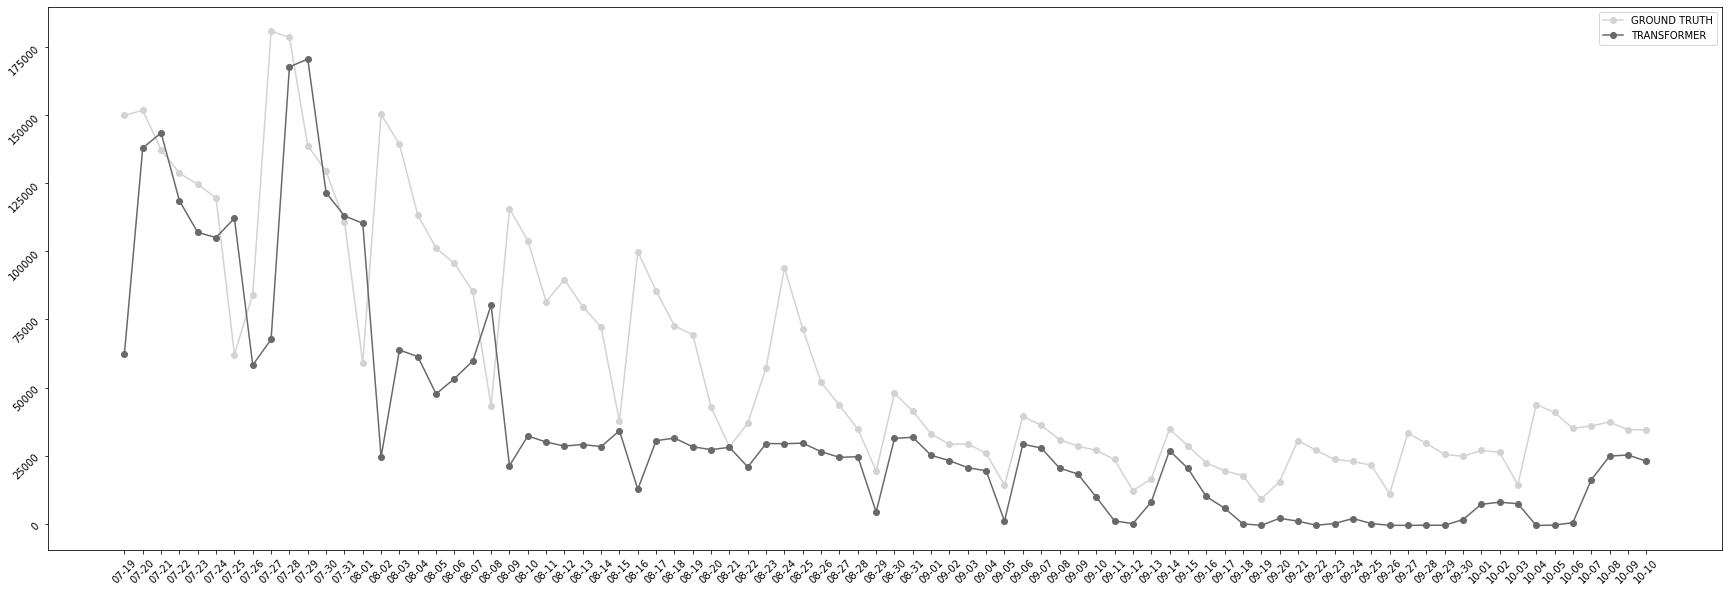

In [90]:
rt_service.display_confirmed_num(test_loader, test_date)

In [100]:

rt_service.get_gt_confrimed_num(), rt_service.get_confirmed_num(2)

(34511, 20721)

In [91]:
days = []
gt = []
bl_pred = []
lstm_pred = []
tf_pred = []

In [92]:
gt_old = gt
bl_pred_old = bl_pred
lstm_pred_old =lstm_pred
tf_pred_old = tf_pred

In [93]:
for i in reversed(range(30)):
    days.append((datetime.today() - timedelta(i+1)).strftime('%Y-%m-%d'))
    rt_service.set_dataset(i)
    gt.append(rt_service.get_gt_confrimed_num())
    bl_pred.append(rt_service.get_confirmed_num(0))
    lstm_pred.append(rt_service.get_confirmed_num(1))
    tf_pred.append(rt_service.get_confirmed_num(2))

<class 'datetime.timedelta'>
2023-01-02
2023-01-03
2023-01-04
2023-01-05
2023-01-06
2023-01-07
2023-01-08
2023-01-09
<class 'datetime.timedelta'>
2023-01-03
2023-01-04
2023-01-05
2023-01-06
2023-01-07
2023-01-08
2023-01-09
2023-01-10
<class 'datetime.timedelta'>
2023-01-04
2023-01-05
2023-01-06
2023-01-07
2023-01-08
2023-01-09
2023-01-10
2023-01-11
<class 'datetime.timedelta'>
error, date: 2023-01-05


ValueError: Wrong number of items passed 4, placement implies 1

In [ ]:
len(days), len(gt)

In [ ]:
days = []
for i in reversed(range(14)):
    days.append((datetime.today() - timedelta(i+1)).strftime('%m-%d'))

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10,10))
fig.set_facecolor('white') 
ax = fig.add_subplot()
ax.plot(days,gt,marker='o',label='A')
ax.plot(days,bl_pred,marker='o',label='B')
plt.fill_between(days, gt, bl_pred, interpolate=True, alpha = 0.25)

In [ ]:
fig = plt.figure(figsize=(10,10))
fig.set_facecolor('white') 
ax = fig.add_subplot()
ax.plot(days,gt,marker='o',label='A')
ax.plot(days,lstm_pred,marker='o',label='C')
plt.fill_between(days, gt, lstm_pred, interpolate=True, alpha = 0.25)

In [ ]:
fig = plt.figure(figsize=(10,10))
fig.set_facecolor('white') 
ax = fig.add_subplot()
ax.plot(days,gt,marker='o',label='A')
ax.plot(days,tf_pred,marker='o',label='D')
plt.fill_between(days, gt, tf_pred, interpolate=True, alpha = 0.25)